#### This notebook performs exploratory data analysis (EDA) on groundwater well data from several Dutch provinces, specdifically, Zeeland, Utrecht, Flevoland, and North Holland. It visualizes chemical measurements such as nitrate and chloride over time, identifies missing values, and maps well locations on a basemap of the Netherlands.

In [103]:
import pandas as pd
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
from IPython.display import Image, display

/Users/Administrator/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [138]:
def plot_well(df_filtered, well, filter_number, variable_to_plot):
    df_well = df_filtered[df_filtered["Well_ID"] == well].sort_values("Date")
    plt.figure(figsize=(10, 4))
    plt.plot(df_well["Date"], df_well[variable_to_plot], marker='o')
    plt.title(f"{variable_to_plot} Levels - Well {well} - Filter {filter_number}")
    plt.xlabel("Date")
    plt.ylabel(f"{variable_to_plot} (mg/L)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_filter(df, filter_number, variable_to_plot, num_wells=10):
    #check number of data points
    df_filtered = df[df["Filter"] == filter_number]
    print(f"Number of data points at filter {filter_number}: {len(df_filtered)}")

    missing_nitrate = df_filtered[df_filtered["Nitrate"].isna()] #check for Nan
    print("Missing Nitrate:", len(missing_nitrate))

    missing_chloride = df_filtered[df_filtered["Chloride"].isna()] #check for Nan
    print("Missing Chloride:", len(missing_chloride))
    print("\n")
    
    # plot first n wells
    # if num_wells:
    #     wells = df_filtered["Well_ID"].unique()[:num_wells]
    #     for well in wells:
    #         plot_well(df_filtered, well, filter_number, variable_to_plot)
    #     print("\n")

    if num_wells:
        # Rank wells by how many non-NaN values they have for the selected variable
        # Find the well with the most non-NaN values for the selected variable
        top_well = (
            df_filtered.groupby("Well_ID")[variable_to_plot]
            .apply(lambda x: x.notna().sum())
            .sort_values(ascending=False)
            .index[0]
        )
        plot_well(df_filtered, top_well, filter_number, variable_to_plot)
        return top_well

def filter_histogram(df, province, n_filters):
    filters = list(range(1, n_filters))
    total_counts = []
    missing_nitrate_counts = []
    missing_chloride_counts = []

    for f in filters:
        df_filt = df[df["Filter"] == f]
        total_counts.append(len(df_filt))
        missing_nitrate_counts.append(df_filt["Nitrate"].isna().sum())
        missing_chloride_counts.append(df_filt["Chloride"].isna().sum())

    x = np.arange(len(filters))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, total_counts, width=width, label="Total", color="#f0a83c")
    plt.bar(x, missing_nitrate_counts, width=width, label="Missing Nitrate", color="#e2713c")
    plt.bar(x + width, missing_chloride_counts, width=width, label="Missing Chloride", color="#e24956")

    plt.xlabel("Filter")
    plt.ylabel("Number of Data Points")
    plt.title(f"{province.capitalize()} - Data Points per Filter")
    plt.xticks(x, filters)
    plt.legend()
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

def well_location_finder(df, highlighted_wells=None):

    df['geometry'] = df['geometry'].apply(wkt.loads) #geometry strings to shapely Point objects
    gdf = gpd.GeoDataFrame(df, geometry='geometry')   # convert to GeoDataFrame (will be done in acc pipeline soon!)

    #coordinate reference system (CRS) to WGS84 (standard GPS)
    gdf.set_crs(epsg=4326, inplace=True)
    gdf_web = gdf.to_crs(epsg=3857)

    # show on top of Netherlands basemap
    ax = gdf_web.plot(figsize=(10, 10), color="darkblue", alpha=0.6, markersize=30)

    if highlighted_wells:
        highlight = gdf_web[gdf_web['Well_ID'].isin(highlighted_wells)]
        highlight.plot(ax=ax, color="crimson", markersize=60, label="Selected Wells")

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.title("Groundwater Wells in the Netherlands")
    plt.show()

# main fuction, that brings everything together
def eda_pipeline(province, variable_to_plot, num_wells=10):
    current_dir = os.getcwd()
    path = os.path.join(current_dir, f'../data/raw/well_chem_data/{province}_well_combined.csv')
    df = pd.read_csv(path)

    # parse datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # sort by date
    df = df.sort_values(by=['Well_ID', 'Date'])

    #total number of data points
    total = len(df)
    print("Number of data points:", total)

    # total nitrate missing
    missing_nitrate = df[df['Nitrate'].isna()]
    print("\nNumber of rows with missing Nitrate:\n", len(missing_nitrate))

    # total chloride missing
    missing_chloride = df[df['Chloride'].isna()]
    print("\nNumber of rows with missing Chloride:\n", len(missing_chloride))
    print("\n")

    # now we check more specific stats, per each filter
    selected_wells = []
    n_filters = df["Filter"].nunique()
    for filter_number in range(1, n_filters+1):
        print(f"Filter: {filter_number}")
        top_well = analyze_filter(df, filter_number, variable_to_plot=variable_to_plot, num_wells=num_wells)
        if top_well:
            selected_wells.append(top_well)

    #summarize stats per well in histogram
    filter_histogram(df, province, n_filters)

    #locate wells on the map
    well_location_finder(df, highlighted_wells=selected_wells)


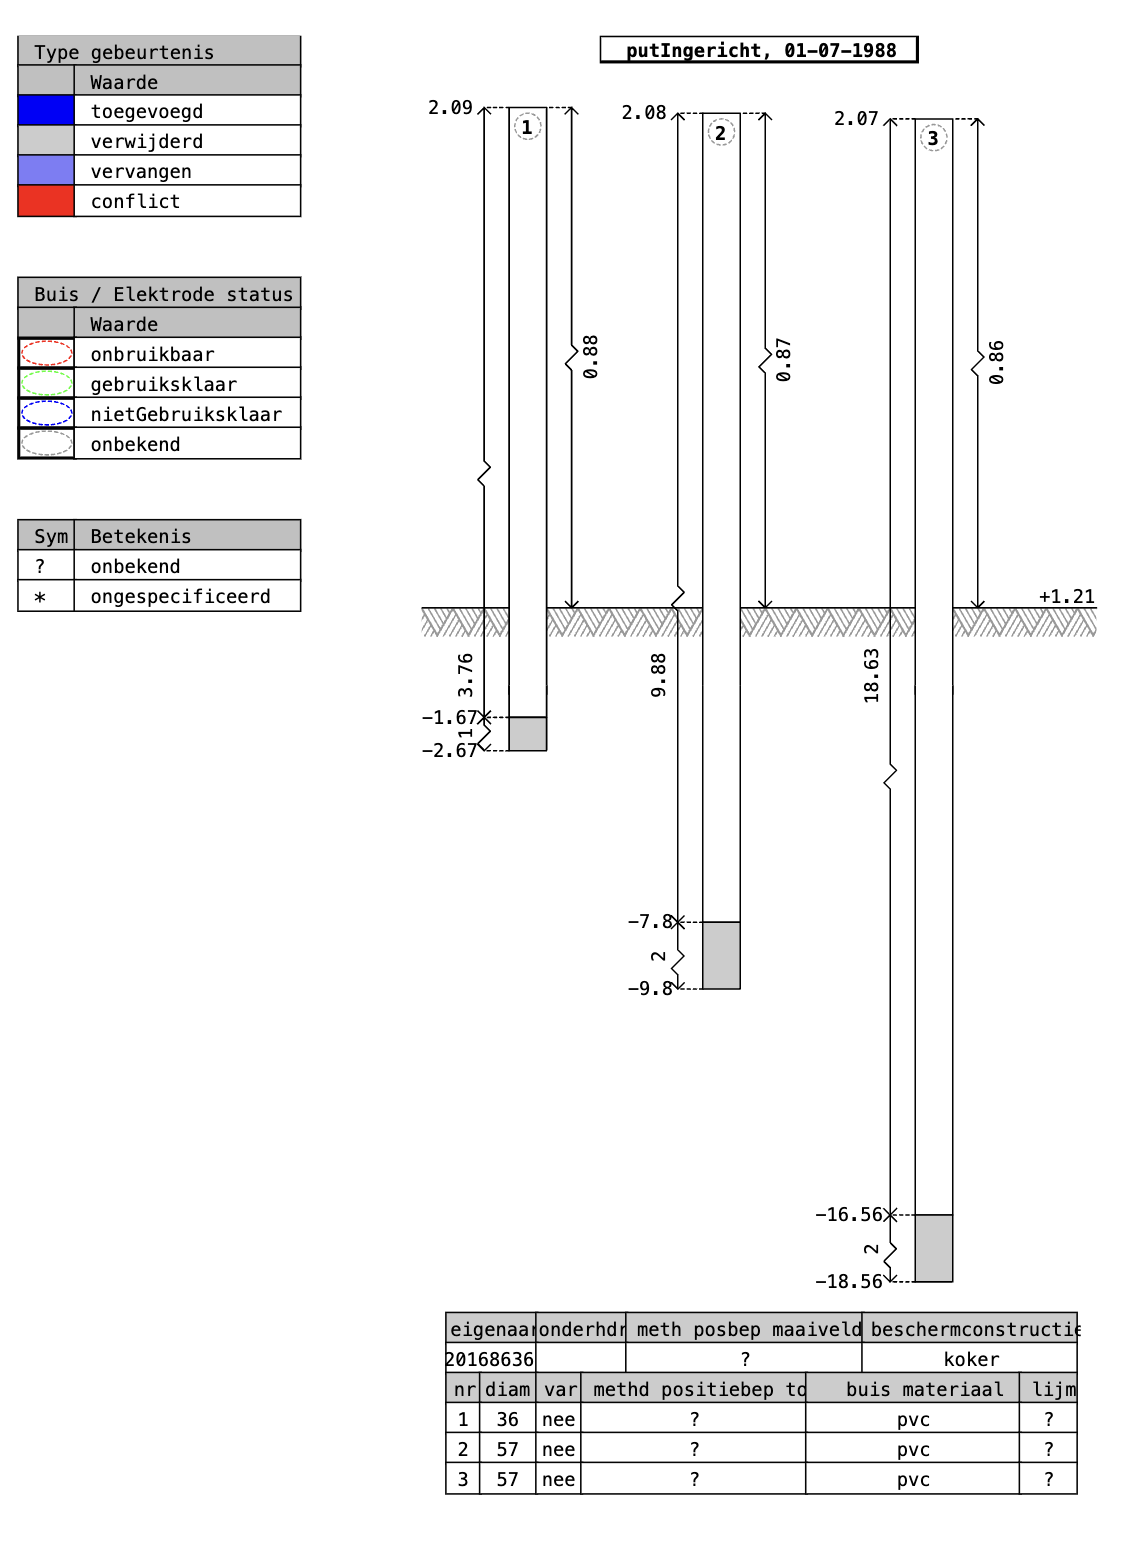

In [134]:
# depth of filters, only 3 filters, usually there are way more :)) up to 10
display(Image(filename="/Users/Administrator/Downloads/Pasted Graphic 5.png", width=600))

# Zeeland

Number of data points: 12991

Number of rows with missing Nitrate:
 10344

Number of rows with missing Chloride:
 248


Filter: 1
Number of data points at filter 1: 5123
Missing Nitrate: 4005
Missing Chloride: 34


Filter: 2
Number of data points at filter 2: 4593
Missing Nitrate: 3852
Missing Chloride: 148


Filter: 3
Number of data points at filter 3: 1768
Missing Nitrate: 1126
Missing Chloride: 47


Filter: 4
Number of data points at filter 4: 661
Missing Nitrate: 546
Missing Chloride: 8


Filter: 5
Number of data points at filter 5: 389
Missing Nitrate: 358
Missing Chloride: 6


Filter: 6
Number of data points at filter 6: 240
Missing Nitrate: 240
Missing Chloride: 5


Filter: 7
Number of data points at filter 7: 90
Missing Nitrate: 90
Missing Chloride: 0


Filter: 8
Number of data points at filter 8: 72
Missing Nitrate: 72
Missing Chloride: 0


Filter: 9
Number of data points at filter 9: 55
Missing Nitrate: 55
Missing Chloride: 0




/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_53789/2738866256.py:95: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


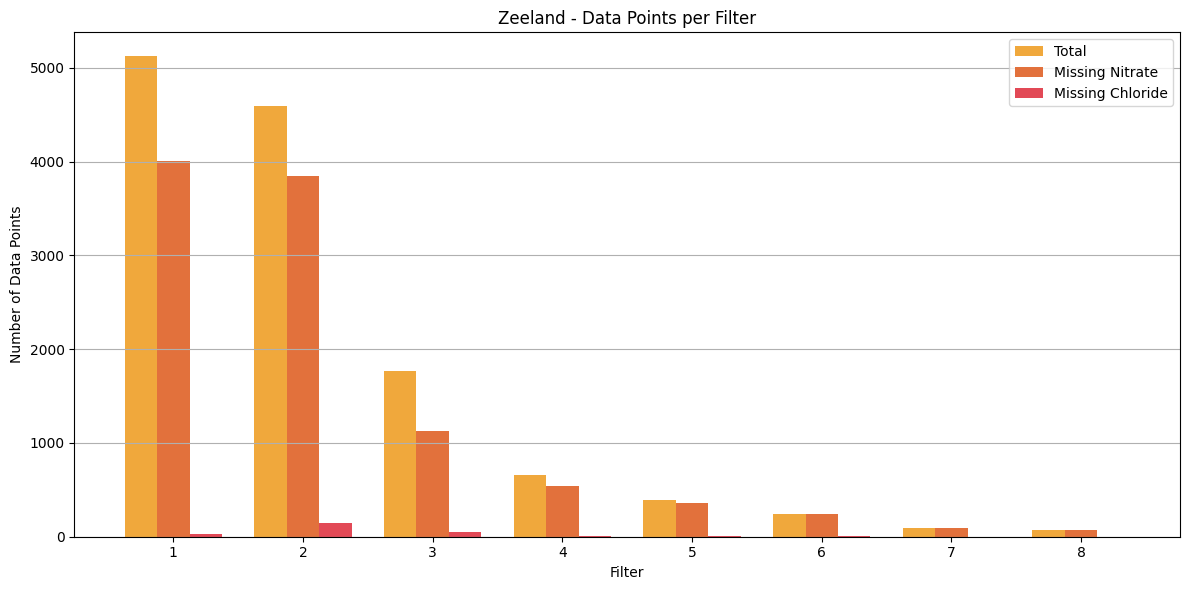

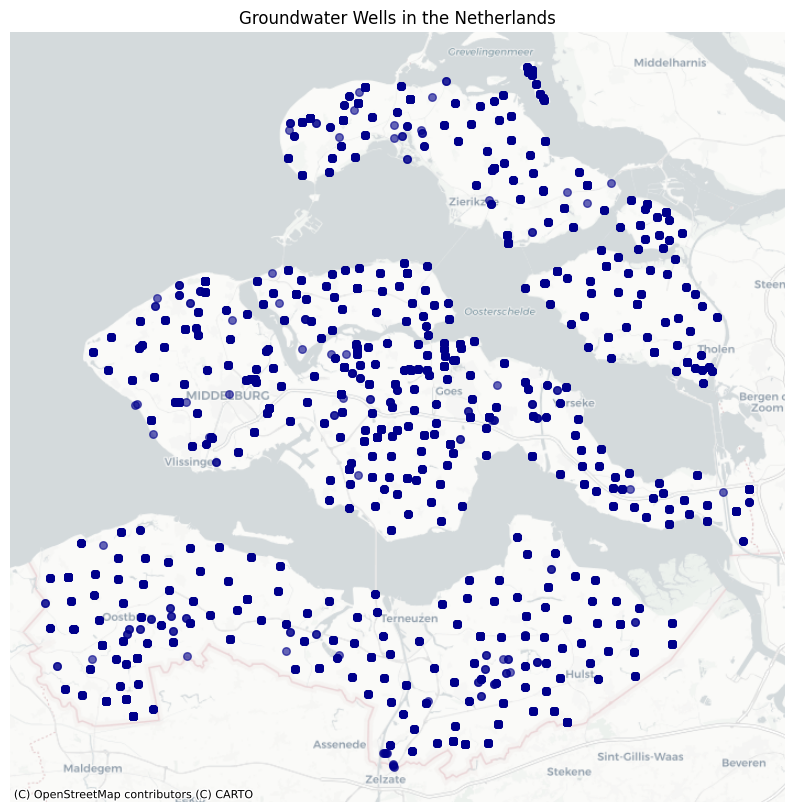

In [121]:
province = "zeeland"
variable_to_plot = "Nitrate"
num_wells = 0

eda_pipeline(province, variable_to_plot, num_wells)


# Flevoland

Number of data points: 2729

Number of rows with missing Nitrate:
 489

Number of rows with missing Chloride:
 361


Filter: 1
Number of data points at filter 1: 1132
Missing Nitrate: 184
Missing Chloride: 139




/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_53789/2339883533.py:100: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


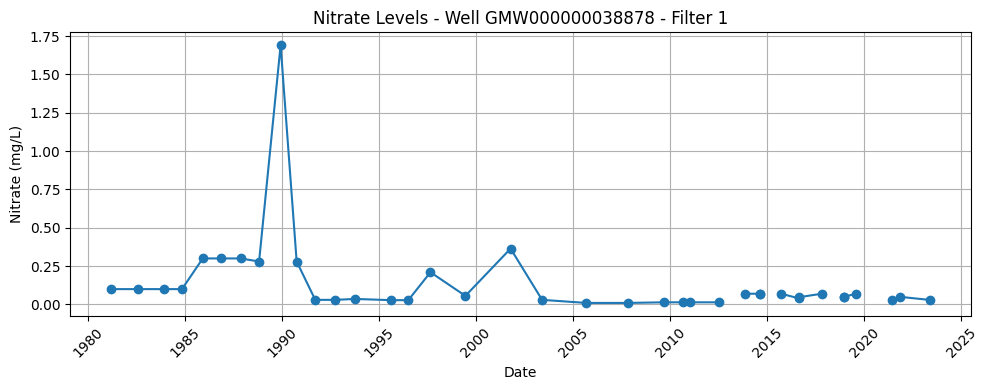

Filter: 2
Number of data points at filter 2: 734
Missing Nitrate: 217
Missing Chloride: 175




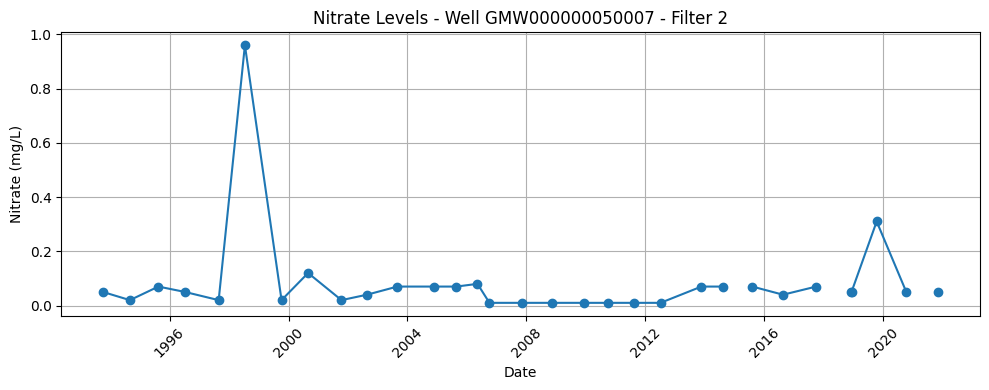

Filter: 3
Number of data points at filter 3: 624
Missing Nitrate: 65
Missing Chloride: 41




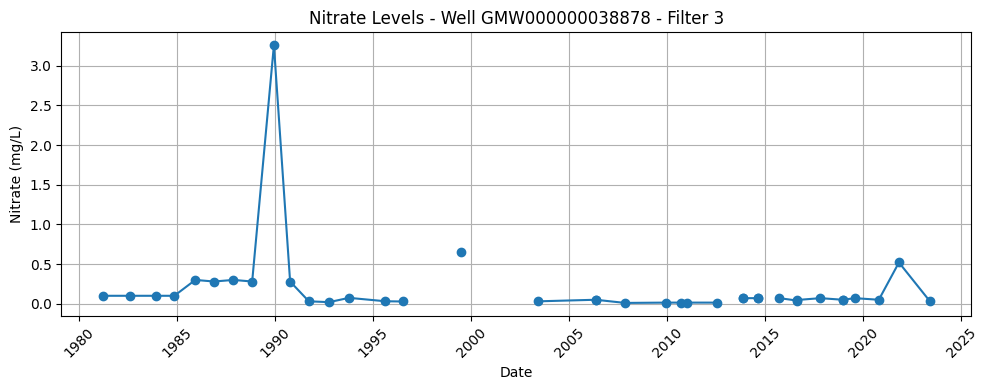

Filter: 4
Number of data points at filter 4: 144
Missing Nitrate: 14
Missing Chloride: 5




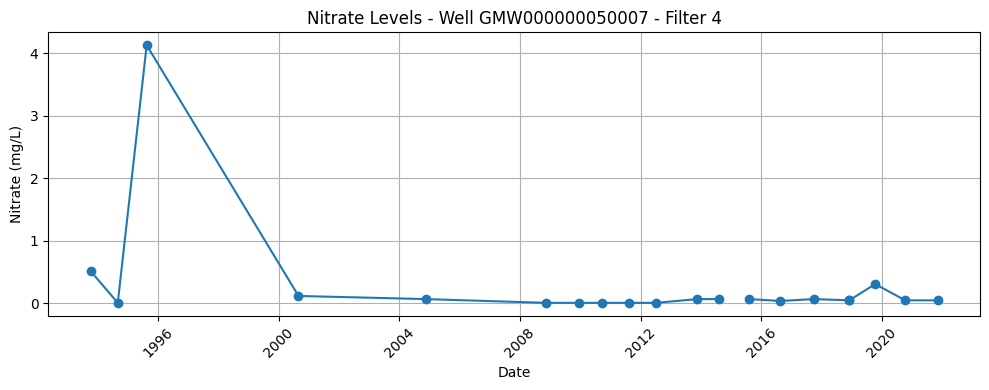

Filter: 5
Number of data points at filter 5: 43
Missing Nitrate: 8
Missing Chloride: 1




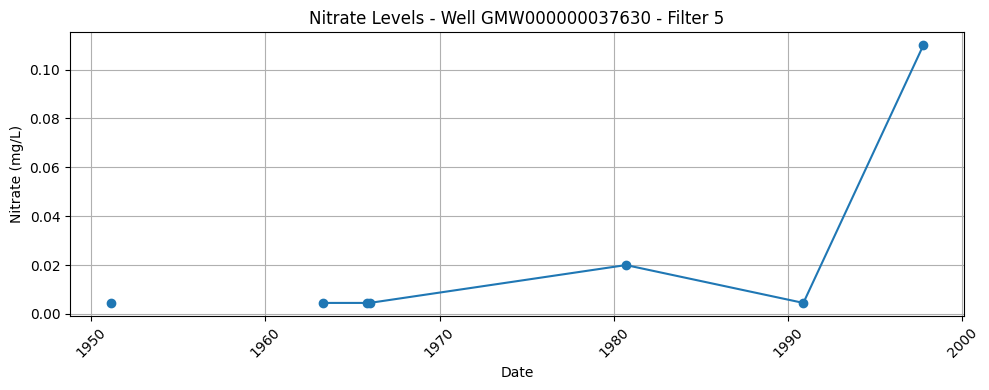

Filter: 6
Number of data points at filter 6: 30
Missing Nitrate: 1
Missing Chloride: 0




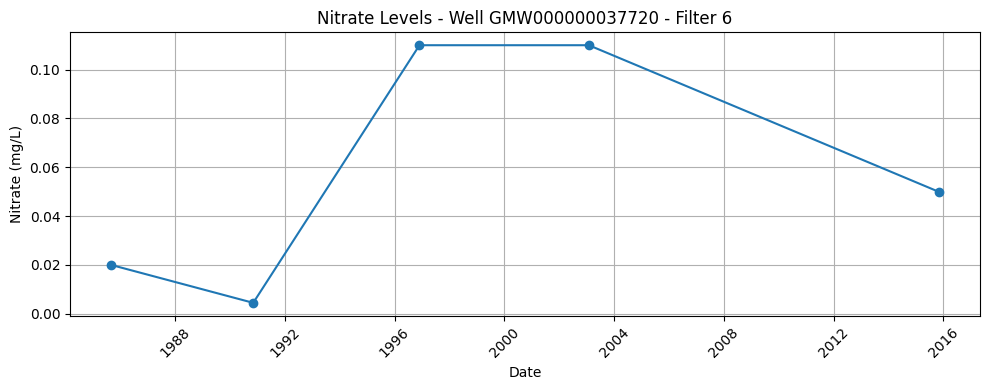

Filter: 7
Number of data points at filter 7: 11
Missing Nitrate: 0
Missing Chloride: 0




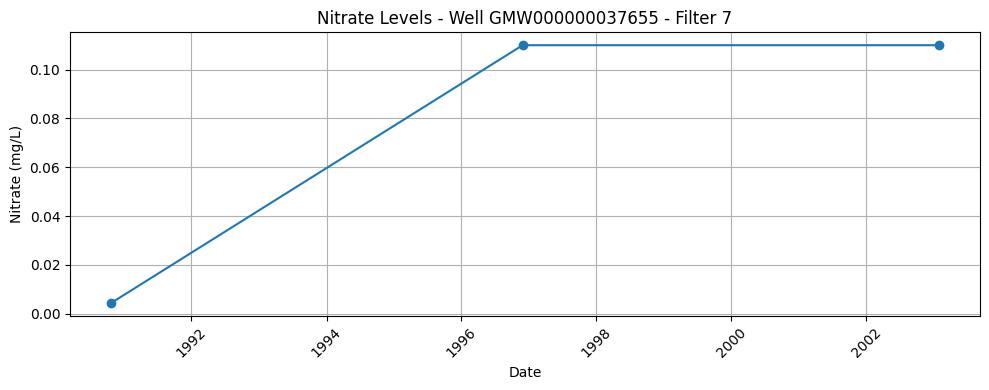

Filter: 8
Number of data points at filter 8: 10
Missing Nitrate: 0
Missing Chloride: 0




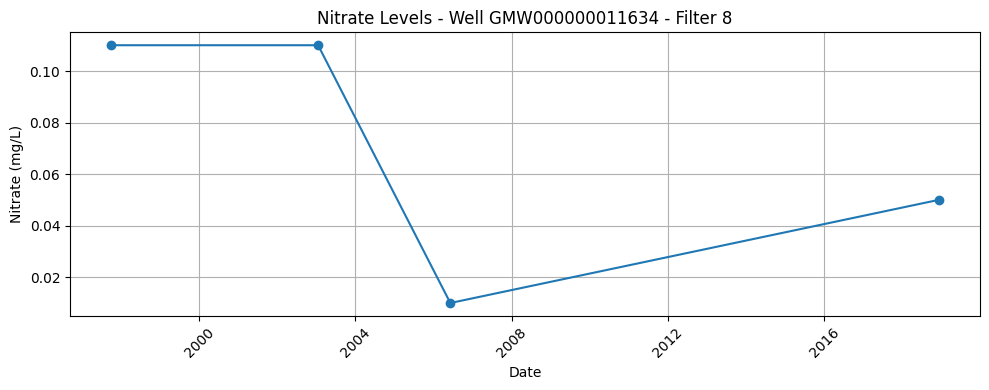

Filter: 9
Number of data points at filter 9: 1
Missing Nitrate: 0
Missing Chloride: 0




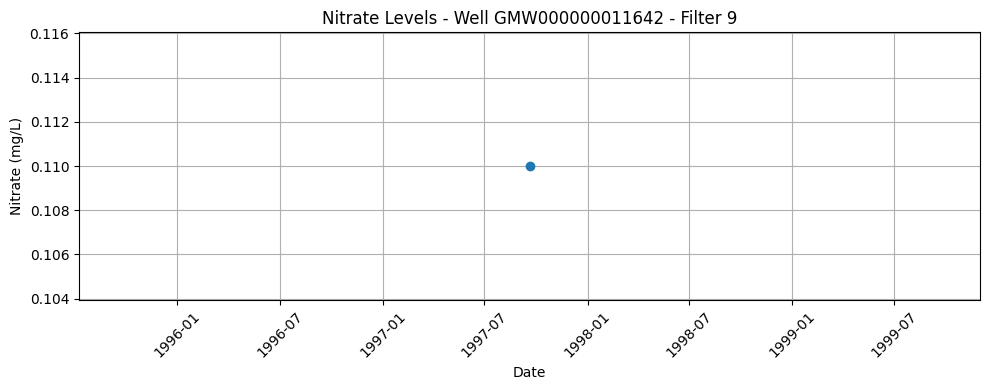

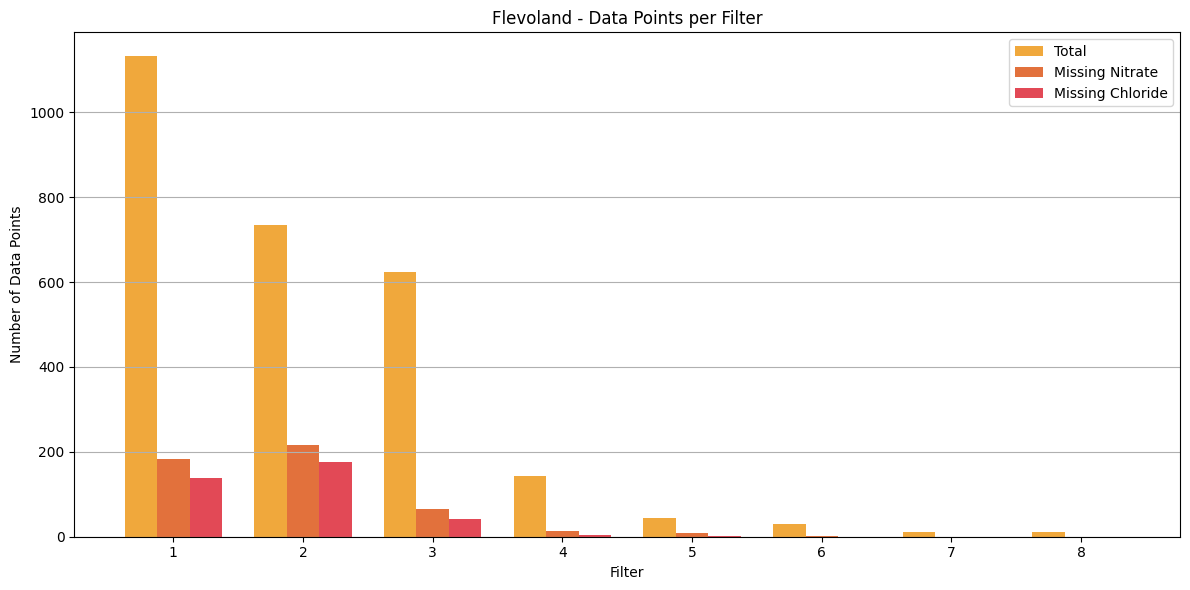

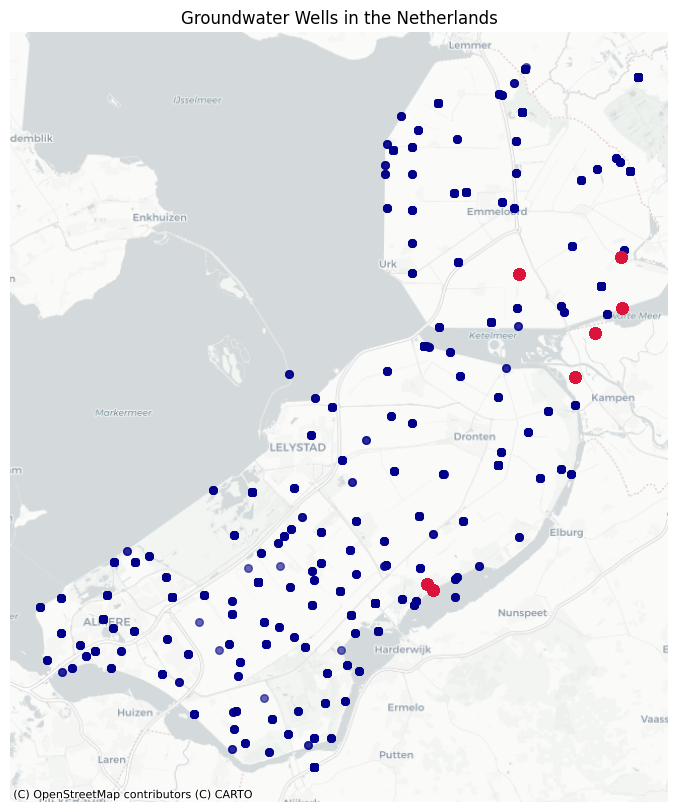

In [139]:
province = "flevoland"
variable_to_plot = "Nitrate"
num_wells = 1

eda_pipeline(province, variable_to_plot, num_wells)

# Utrecht

Number of data points: 1915

Number of rows with missing Nitrate:
 261

Number of rows with missing Chloride:
 261


Filter: 1
Number of data points at filter 1: 877
Missing Nitrate: 38
Missing Chloride: 37




/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_53789/3534203345.py:100: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


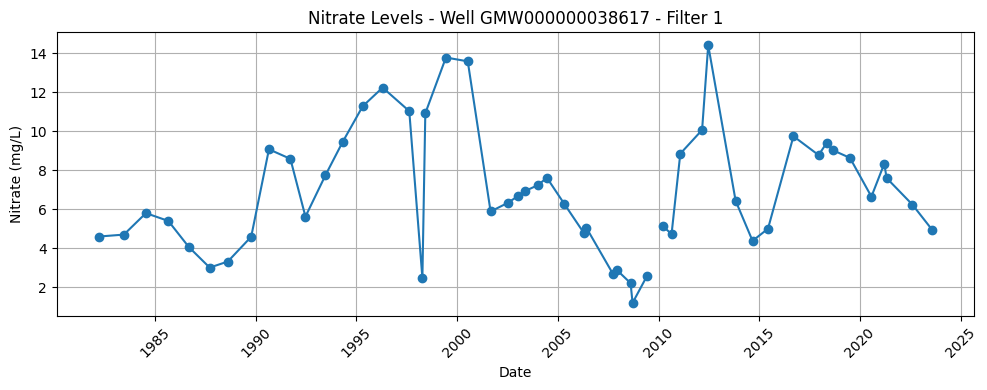

Filter: 2
Number of data points at filter 2: 430
Missing Nitrate: 153
Missing Chloride: 154




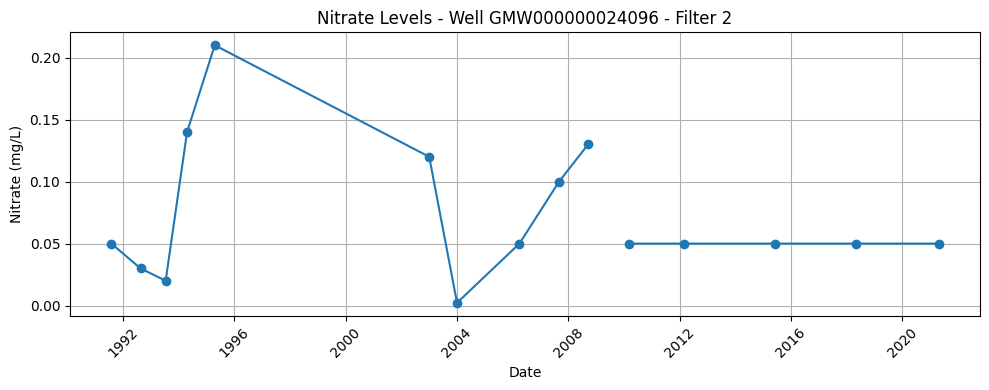

Filter: 3
Number of data points at filter 3: 479
Missing Nitrate: 64
Missing Chloride: 64




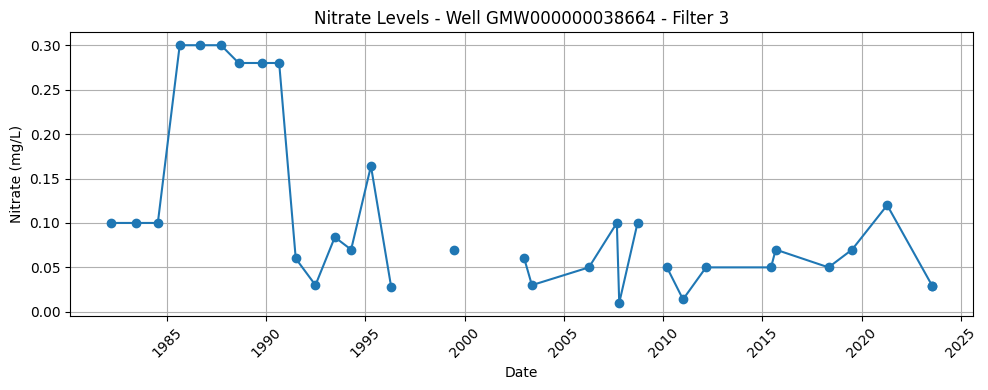

Filter: 4
Number of data points at filter 4: 129
Missing Nitrate: 6
Missing Chloride: 6




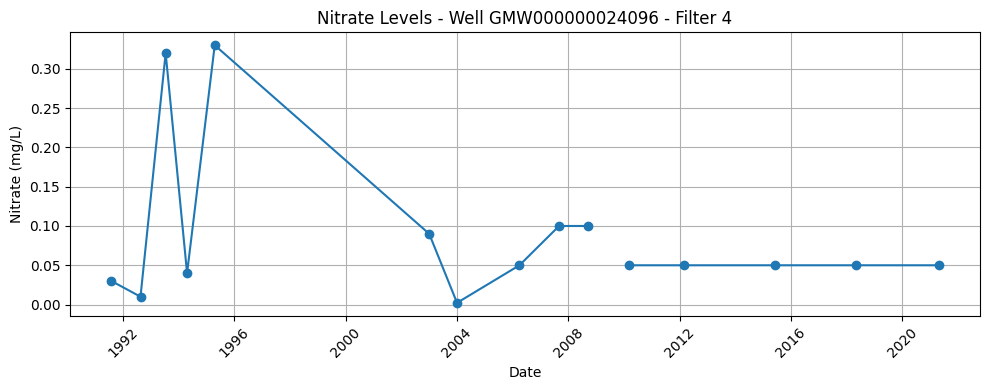

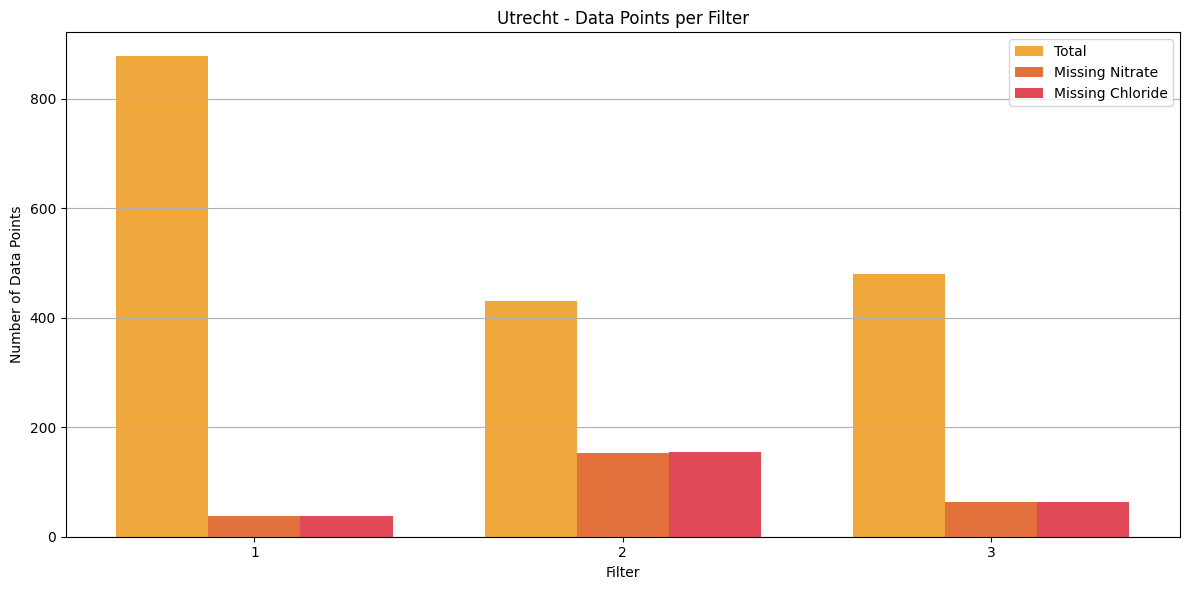

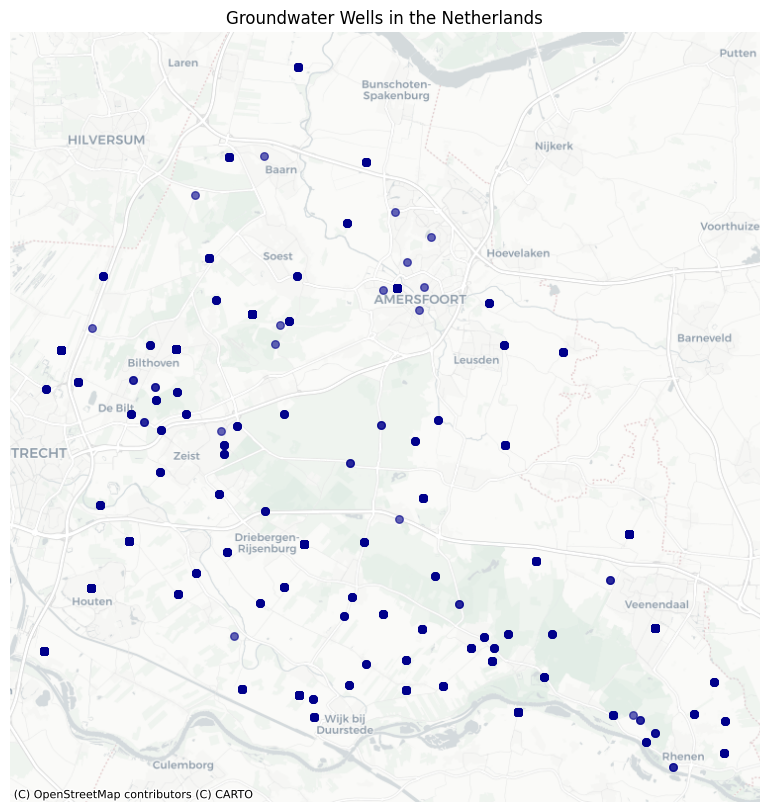

In [137]:
province = "utrecht"
variable_to_plot = "Nitrate"
num_wells = 1

eda_pipeline(province, variable_to_plot, num_wells)

# Noord Holland

Number of data points: 756

Number of rows with missing Nitrate:
 120

Number of rows with missing Chloride:
 120


Filter: 1
Number of data points at filter 1: 338
Missing Nitrate: 8
Missing Chloride: 8




/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_53789/2738866256.py:95: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


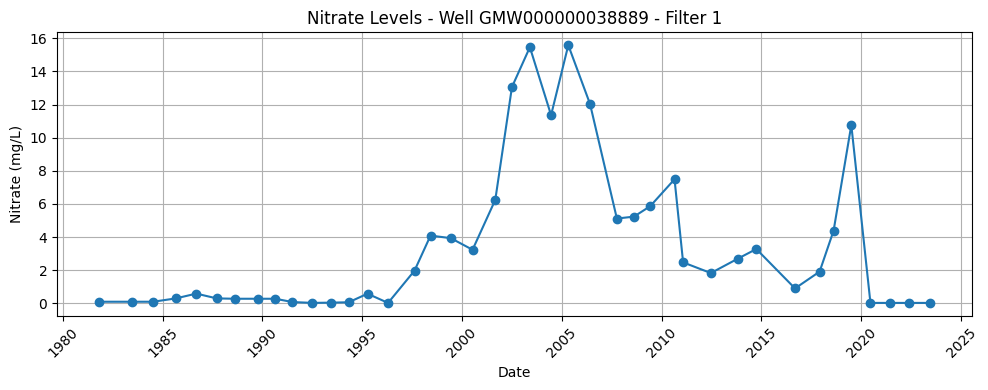

Filter: 2
Number of data points at filter 2: 181
Missing Nitrate: 70
Missing Chloride: 70




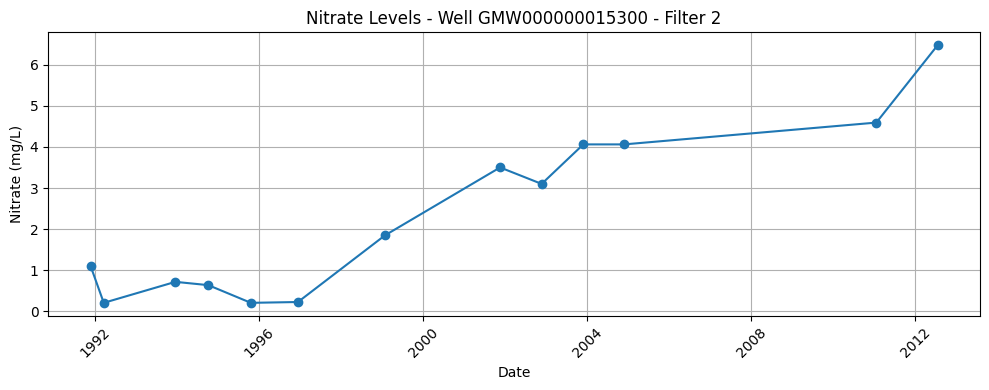

Filter: 3
Number of data points at filter 3: 179
Missing Nitrate: 35
Missing Chloride: 35




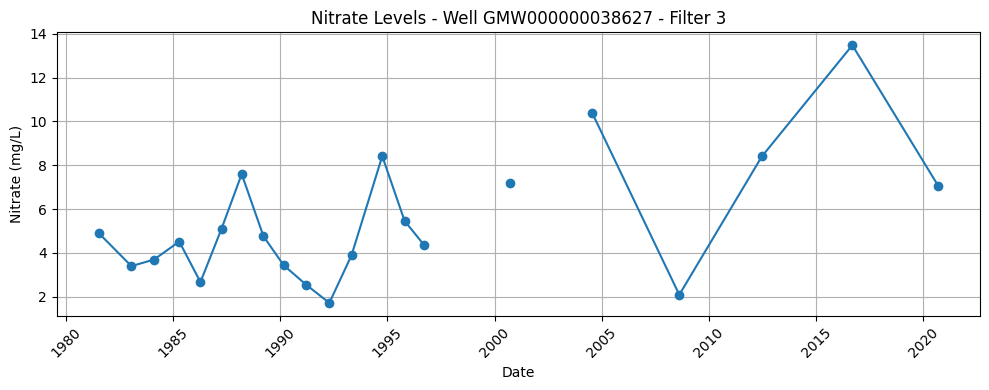

Filter: 4
Number of data points at filter 4: 50
Missing Nitrate: 5
Missing Chloride: 5




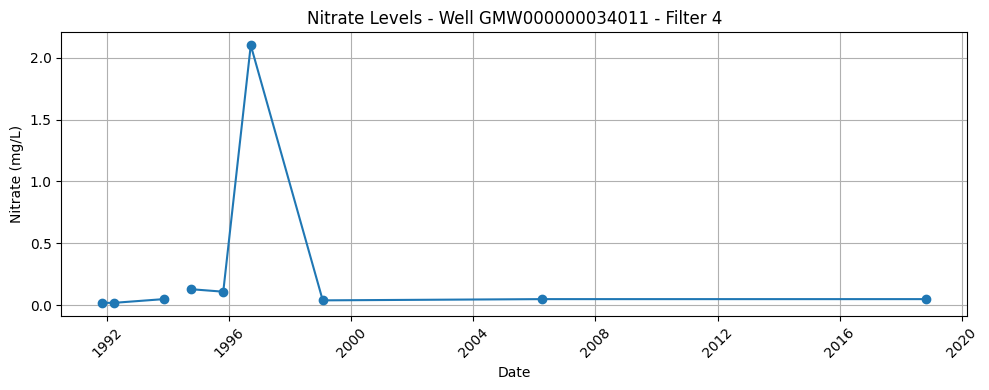

Filter: 5
Number of data points at filter 5: 4
Missing Nitrate: 1
Missing Chloride: 1




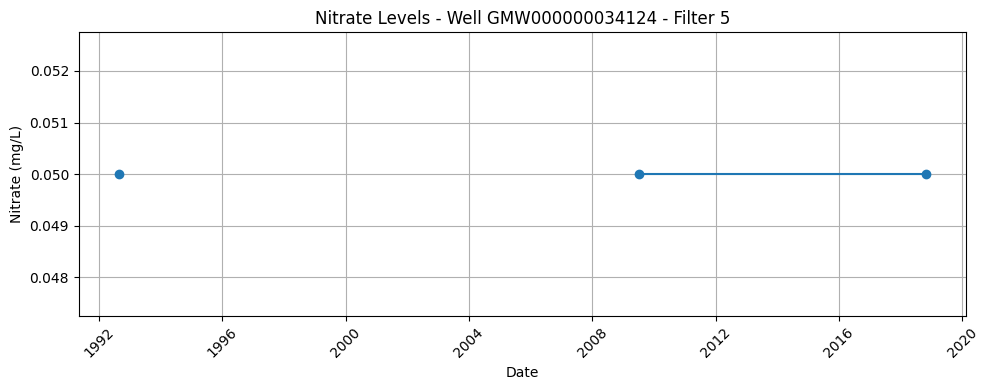

Filter: 6
Number of data points at filter 6: 4
Missing Nitrate: 1
Missing Chloride: 1




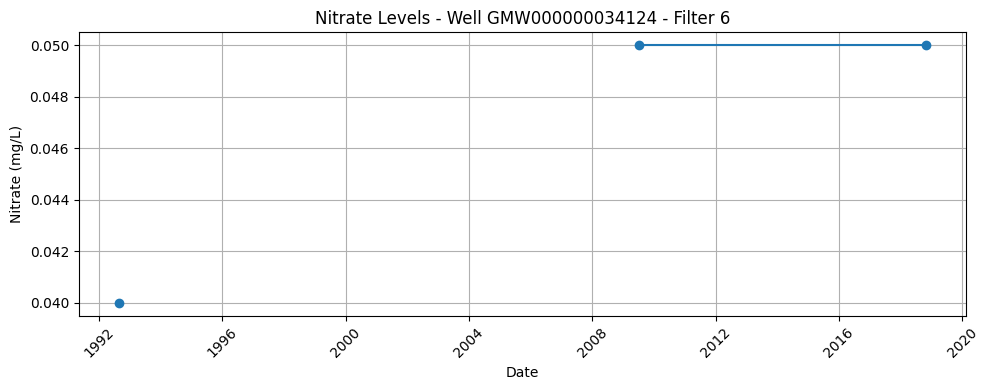

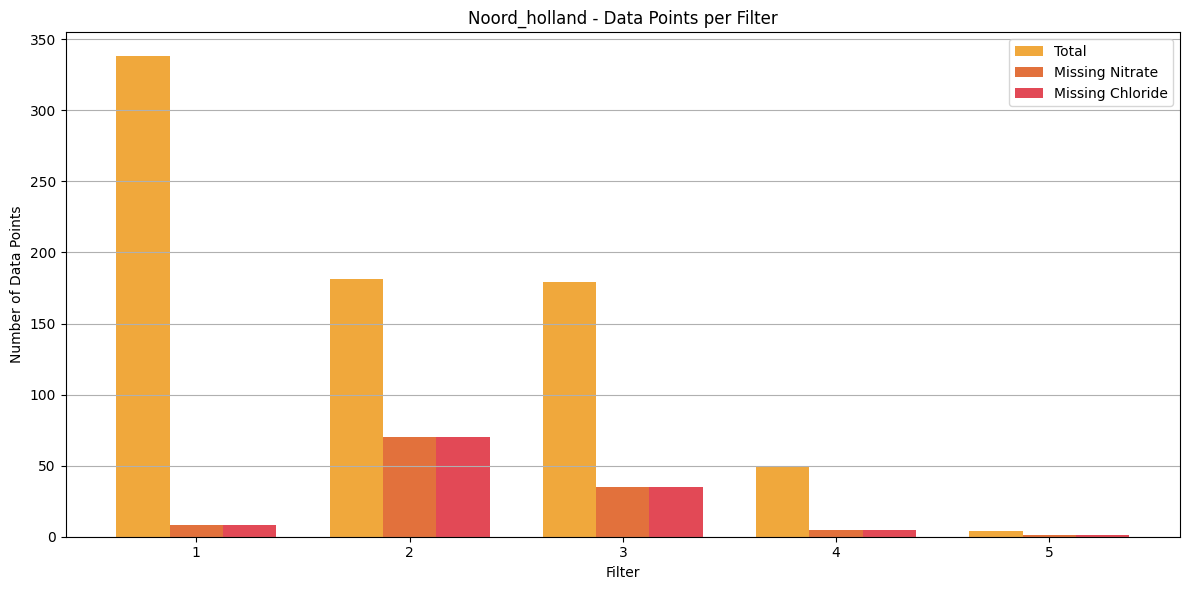

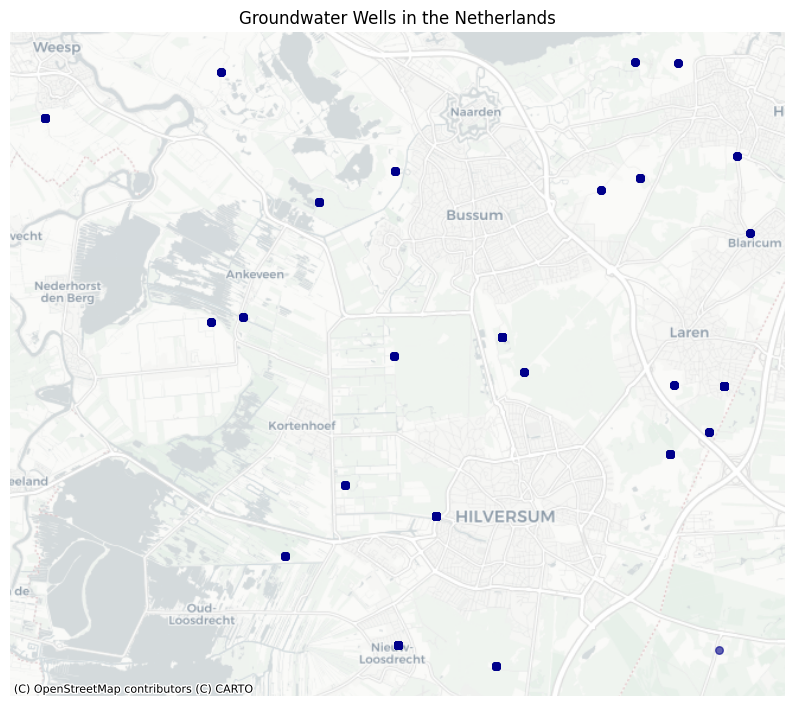

In [127]:
province = "noord_holland"
variable_to_plot = "Nitrate"
num_wells = 1

eda_pipeline(province, variable_to_plot, num_wells)